In [27]:
import copy
import timm
import torch
import urllib
from PIL import Image
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import matplotlib.pyplot as plt
from torchvision.transforms import PILToTensor, ToPILImage
import torch.nn.functional as F
from tqdm import tqdm

from apm_util import *

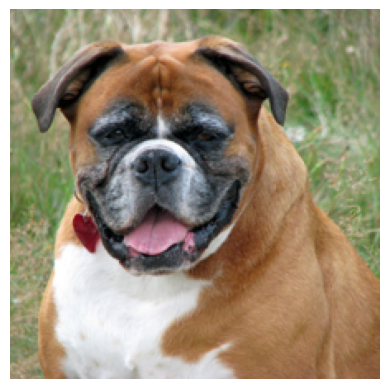

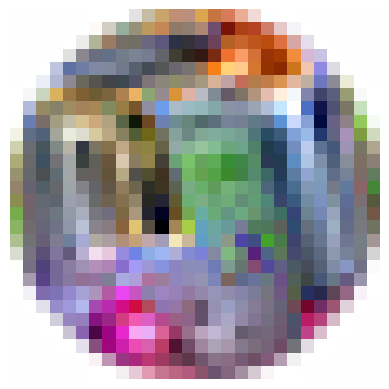

In [28]:
HEIGHT, WIDTH = 224, 224
PATCH_HEIGHT, PATCH_WIDTH = WIDTH//8, HEIGHT//8

# Load from Hub
model = timm.create_model("resnet50", pretrained=True)
# Set model to eval mode for inference
model.eval()

# Get imagenet class mappings
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
filename = "imagenet_classes.txt"
urllib.request.urlretrieve(url, filename) 
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# Create Transform for input image tensors
transform = create_transform(**resolve_data_config({}, model=model))

# Use your own image file here...
#image = Image.open('saint_bernard.jpg').convert('RGBA')
image = Image.open('Boxer-dog.jpg').convert('RGBA')
original_W, original_H = image.size
min_size = min(original_W, original_H)
image = image.crop((
    (original_W - min_size)//2,
    (original_H - min_size)//2,
    (original_W + min_size)//2,
    (original_H + min_size)//2,
))
image = image.resize((HEIGHT, WIDTH))

plt.imshow(image)
plt.axis('off')
plt.show()

# adversarial patch
patch_image = Image.open('adversarial_patch_toaster.png').convert('RGBA')
patch_image = patch_image.resize((PATCH_HEIGHT, PATCH_WIDTH))

plt.imshow(patch_image)
plt.axis('off')
plt.show()

Original category: boxer
Probability before: 0.9972541928291321
Probability after: 0.996653139591217

boxer 0.9972541928291321
bull mastiff 0.00022967344557400793
Saint Bernard 5.488876922754571e-05
French bulldog 4.6379540435737e-05
Staffordshire bullterrier 4.3804189772345126e-05

boxer 0.996653139591217
bull mastiff 0.00028851875686086714
Saint Bernard 7.369422382907942e-05
French bulldog 6.20283535681665e-05
Staffordshire bullterrier 6.060892337700352e-05


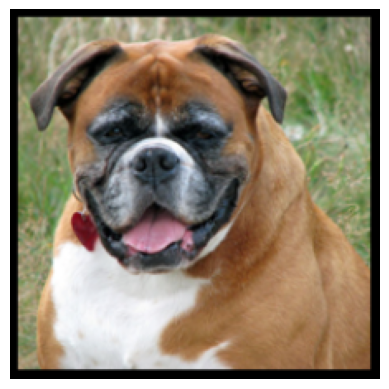

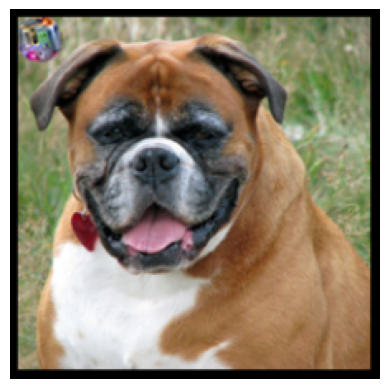

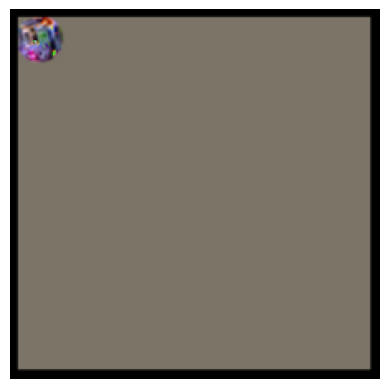

In [29]:
patched_image = copy.deepcopy(image)
patched_image.paste(patch_image, (5, 5), patch_image)

# convert to RGB
image = image.convert("RGB")
patched_image = patched_image.convert("RGB")

# Process PIL image with transforms and add a batch dimension
x = transform(image).unsqueeze(0)
patched = transform(patched_image).unsqueeze(0)

y_pred_before = model(x)
y_pred_after = model(patched)

probabilities_before = torch.nn.functional.softmax(y_pred_before[0], dim=0)
probabilities_after = torch.nn.functional.softmax(y_pred_after[0], dim=0)

# Print top categories per image
compare_probs(categories, probabilities_before, probabilities_after, verbose=True)
print()
print_topk(categories, probabilities_before, 5)
print()
print_topk(categories, probabilities_after, 5)


# Display initial image
initial_image = inverse_transform(x.squeeze())
plt.imshow(initial_image)
plt.axis('off')
plt.show()

# Display final image
final_image = inverse_transform(patched.squeeze())
plt.imshow(final_image)
plt.axis('off')
plt.show()

# diff
diff_image = inverse_transform((patched - x).squeeze())
plt.imshow(diff_image)
plt.axis('off')
plt.show()

Original category: boxer
Probability before: 0.9972541928291321
Probability after: 2.9255302251840476e-06

boxer 0.9972541928291321
bull mastiff 0.00022967344557400793
Saint Bernard 5.488876922754571e-05
French bulldog 4.6379540435737e-05
Staffordshire bullterrier 4.3804189772345126e-05

kelpie 0.4191402792930603
dhole 0.21472862362861633
Staffordshire bullterrier 0.21133358776569366
porcupine 0.10620149224996567
weasel 0.031162811443209648


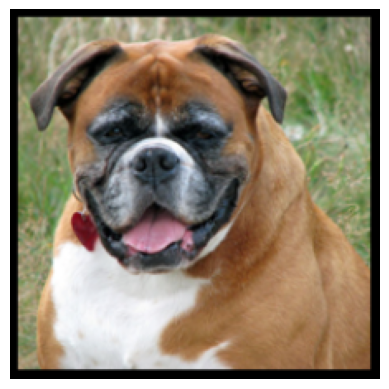

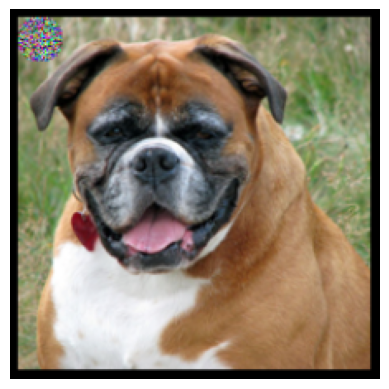

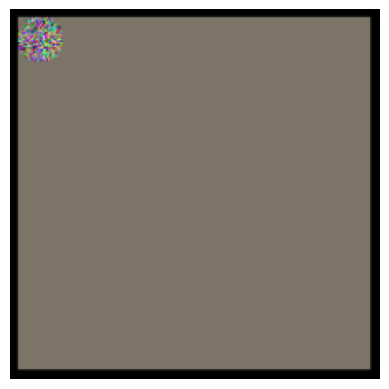

In [30]:
# convert to RGB
image = image.convert("RGB")
patch_image = patch_image.convert("RGB")

# Process PIL image with transforms and add a batch dimension
x = transform(image).unsqueeze(0)

# naively add patch to the image
patched = copy.deepcopy(x)
patch = PILToTensor()(patch_image).unsqueeze(0)
patched[:, :, :PATCH_HEIGHT, :PATCH_WIDTH] += patch

y_pred_before = model(x)
y_pred_after = model(patched)

probabilities_before = torch.nn.functional.softmax(y_pred_before[0], dim=0)
probabilities_after = torch.nn.functional.softmax(y_pred_after[0], dim=0)

# Print top categories per image
compare_probs(categories, probabilities_before, probabilities_after, verbose=True)
print()
print_topk(categories, probabilities_before, 5)
print()
print_topk(categories, probabilities_after, 5)

# Display initial image
initial_image = inverse_transform(x.squeeze())
plt.imshow(initial_image)
plt.axis('off')
plt.show()

# Display final image
final_image = inverse_transform(patched.squeeze())
plt.imshow(final_image)
plt.axis('off')
plt.show()

# diff
diff_image = inverse_transform((patched - x).squeeze())
plt.imshow(diff_image)
plt.axis('off')
plt.show()

100%|██████████| 20/20 [00:02<00:00,  7.68it/s]


Text(0, 0.5, 'Original label probabilty')

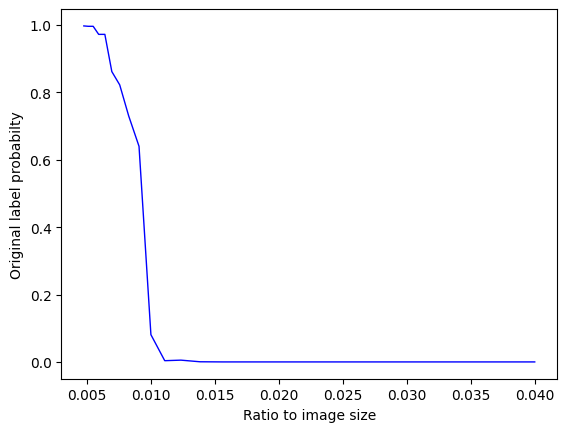

In [32]:
#image = Image.open('saint_bernard.jpg').convert("RGB")
image = Image.open('Boxer-dog.jpg').convert('RGB')
patch_image = Image.open('adversarial_patch_toaster.png').convert("RGB")

# Process PIL image with transforms and add a batch dimension
x = transform(image).unsqueeze(0)
y_pred_before = model(x)
prob_before = torch.nn.functional.softmax(y_pred_before[0], dim=0)

ratios = []
label_probs = []
for i in tqdm(range(50, 150, 5)):
    denom = i / 10
    ratio = (1 / denom)**2
    ratios.append(ratio)
    patch_height, patch_width = int(HEIGHT/denom), int(WIDTH/denom)
    
    patched = copy.deepcopy(x)
    curr_patch_image = patch_image.resize((patch_height, patch_width))
    patch = PILToTensor()(curr_patch_image).unsqueeze(0)
    patched[:, :, :patch_height, :patch_width] += patch
    
    y_pred_after = model(patched)
    prob_after = torch.nn.functional.softmax(y_pred_after[0], dim=0)

    _, _, label_prob = compare_probs(categories, prob_before, prob_after)
    label_probs.append(label_prob)

plt.plot(ratios, label_probs, 'b-', linewidth=1, markersize=2)
plt.xlabel("Ratio to image size")
plt.ylabel("Original label probabilty")